<a href="https://colab.research.google.com/github/kamilahoudek/Projects/blob/master/FINAL%20project/Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor

Dataset k projektu
https://www.kaggle.com/datasets/denizkavi1/brain-tumor?resource=download

1. 1 Meningioma samples (708 files)
2. 2 Glioma samples (1426 files)
3. 3 Pituitary tumor samples (930 files)



# Step 1: Understanding the Dataset
Download the dataset from Kaggle.
Explore the dataset structure (number of classes, sample images, etc.).
Check for data imbalances and preprocessing needs.


## Download and extraxt dataset, locate the Extracted Dataset

In [34]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("denizkavi1/brain-tumor")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/denizkavi1/brain-tumor/versions/2


In [35]:
#This will confirm the dataset folder structure.
import os

dataset_root = "/root/.cache/kagglehub/datasets/denizkavi1/brain-tumor/versions/"
print("Available dataset versions:", os.listdir(dataset_root))

# Select the latest version
latest_version = os.listdir(dataset_root)[-1]  # Get the most recent version
dataset_path = os.path.join(dataset_root, latest_version)
print("Using dataset path:", dataset_path)

# List classes inside the dataset
print("Dataset structure:", os.listdir(dataset_path))


Available dataset versions: ['2']
Using dataset path: /root/.cache/kagglehub/datasets/denizkavi1/brain-tumor/versions/2
Dataset structure: ['1', '2', '3']


## Count Images Per Category

In [36]:
#Count Images Per Category
# Count images in each category
for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    if os.path.isdir(category_path):
        print(f"{category}: {len(os.listdir(category_path))} images")


1: 708 images
2: 1426 images
3: 930 images


## Display Sample Images

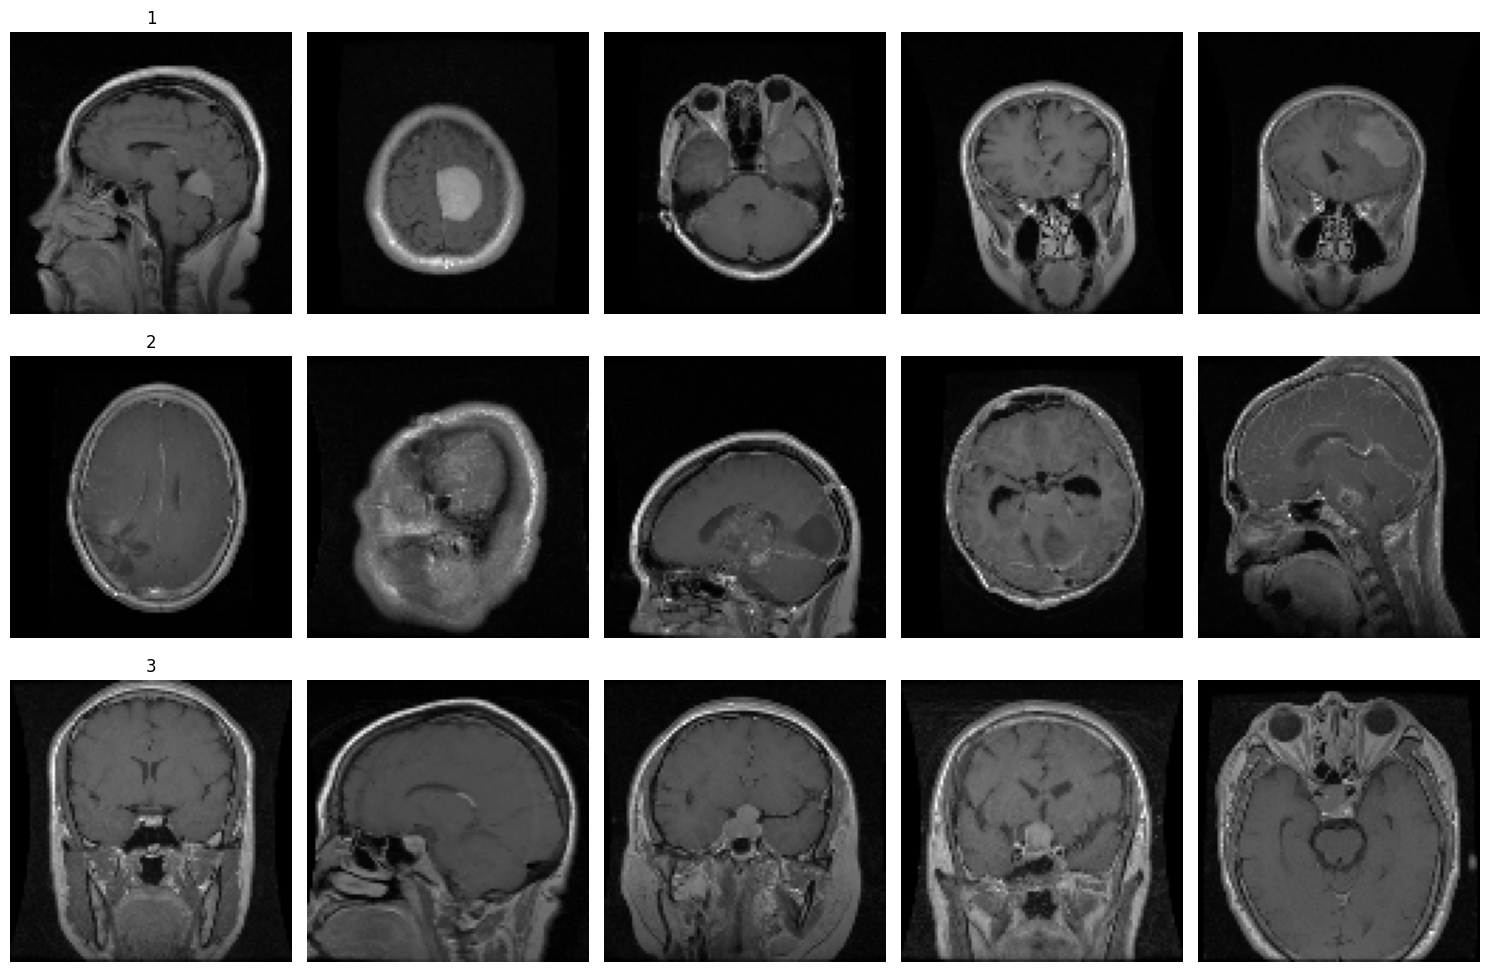

In [37]:
#Display Sample Images
import matplotlib.pyplot as plt
import cv2
import random

def show_sample_images(dataset_path, num_samples=5):
    categories = os.listdir(dataset_path)
    fig, axes = plt.subplots(len(categories), num_samples, figsize=(15, 10))

    for i, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        images = random.sample(os.listdir(category_path), num_samples)

        for j, img_name in enumerate(images):
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
            img = cv2.resize(img, (100, 100))  # Resize for consistency
            axes[i, j].imshow(img, cmap="gray")
            axes[i, j].axis("off")
            if j == 0:
                axes[i, j].set_title(category)

    plt.tight_layout()
    plt.show()

show_sample_images(dataset_path)

## Checking dataset balance
To see if the dataset is balanced across classes:

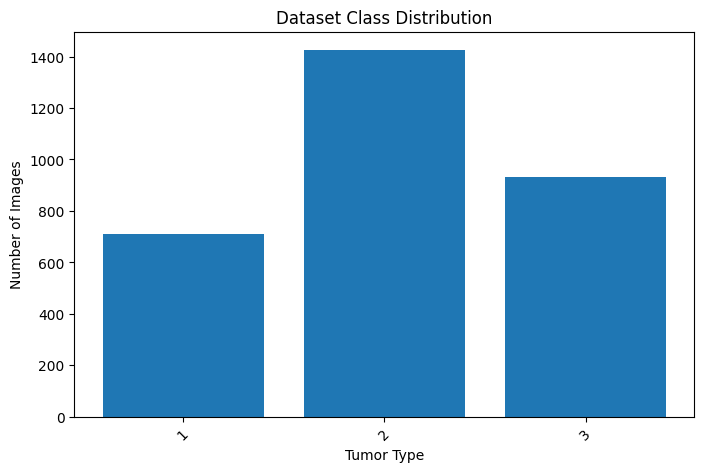

In [38]:
import pandas as pd

# Count images per category
data_counts = {category: len(os.listdir(os.path.join(dataset_path, category)))
               for category in os.listdir(dataset_path)}

# Convert to DataFrame
df = pd.DataFrame(list(data_counts.items()), columns=["Category", "Image Count"])

# Plot
plt.figure(figsize=(8,5))
plt.bar(df["Category"], df["Image Count"])
plt.xlabel("Tumor Type")
plt.ylabel("Number of Images")
plt.title("Dataset Class Distribution")
plt.xticks(rotation=45)
plt.show()


# Step 2: Data Preprocessing
Resize images to a consistent shape (e.g., 224x224 for CNNs).
Normalize pixel values (e.g., scale between 0 and 1).
Apply data augmentation to improve generalization.

In [39]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define parameters
IMG_SIZE = (224, 224)  # Image size
BATCH_SIZE = 32  # Number of images per training step
dataset_path = dataset_path  # The path from previous steps

# Define ImageDataGenerator for augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values
    rotation_range=20,  # Random rotation
    width_shift_range=0.2,  # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,  # Shearing
    zoom_range=0.2,  # Zoom
    horizontal_flip=True,  # Flip images horizontally
    validation_split=0.2  # Split 20% of data for validation
)

# Load training dataset
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Because we have multiple tumor classes
    subset='training'
)

# Load validation dataset
val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 2452 images belonging to 3 classes.
Found 612 images belonging to 3 classes.


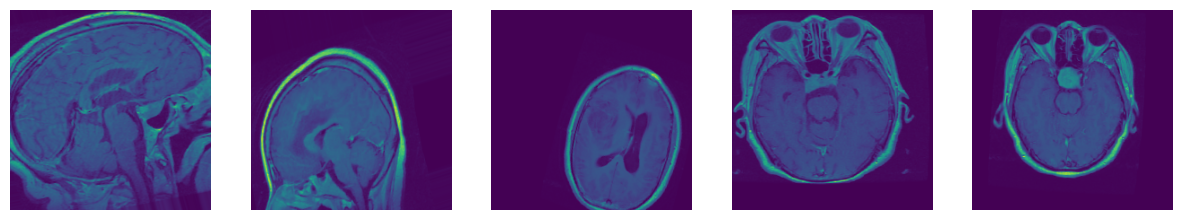

In [40]:
import matplotlib.pyplot as plt

# Get a batch of images
sample_images, sample_labels = next(train_generator)

# Plot sample images
fig, axes = plt.subplots(1, 5, figsize=(15,5))
for i in range(5):
    axes[i].imshow(sample_images[i])
    axes[i].axis('off')
plt.show()


In [41]:
print("Class labels:", train_generator.class_indices)


Class labels: {'1': 0, '2': 1, '3': 2}



# Step 3: Model Selection
Use a CNN (Convolutional Neural Network) for feature extraction.
Consider Transfer Learning (e.g., ResNet50, VGG16, EfficientNet).
Experiment with architectures to improve accuracy.


- Resize images to 224x224
- Normalize pixel values to [0, 1]
- Apply data augmentation
- Create train/validation splitsList item

-Using a pre-trained model like ResNet50, VGG16, or EfficientNet will speed up training and improve accuracy by leveraging features learned from millions of images.




##MobileNetV2
- EfficientNetB0 Pre-trained Model -lightweight, accurate, and optimized for deep learning on medical images.
-Models like EfficientNet, ResNet, and VGG16 were trained on ImageNet, which has RGB images.

In [53]:
IMG_SIZE = (128, 128)  # Reduced image size for faster training

# Load MobileNetV2 with smaller input shape
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze base model for feature extraction
base_model.trainable = False

# Add custom classifier on top
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(3, activation='softmax')(x)  # 3 classes

# Define final model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 64, 64, 32)     │            864 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 64, 64, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 64, 64, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 64, 64, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 64, 64, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 64, 64, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 64, 64, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 64, 64, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 64, 64, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 65, 65, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 32, 32, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,915,395 (11.12 MB)

 Trainable params: 657,411 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [55]:
IMG_SIZE = (128, 128)  # Match model input shape

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,  # Resize images to 128x128
    batch_size=16,
    class_mode='categorical',
    color_mode="rgb"  # Convert grayscale to RGB
)

val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,  # Resize validation images to 128x128
    batch_size=16,
    class_mode='categorical',
    color_mode="rgb"
)

Found 3064 images belonging to 3 classes.
Found 3064 images belonging to 3 classes.


In [56]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5  # Faster training
)

Epoch 1/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.8092 - loss: 0.4926 - val_accuracy: 0.8362 - val_loss: 0.3961
Epoch 2/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 184s 961ms/step - accuracy: 0.8186 - loss: 0.4307 - val_accuracy: 0.8384 - val_loss: 0.3825
Epoch 3/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 185s 963ms/step - accuracy: 0.8334 - loss: 0.4052 - val_accuracy: 0.8672 - val_loss: 0.3270
Epoch 4/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 234s 1s/step - accuracy: 0.8488 - loss: 0.3708 - val_accuracy: 0.8600 - val_loss: 0.3501
Epoch 5/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 185s 963ms/step - accuracy: 0.8407 - loss: 0.3936 - val_accuracy: 0.8747 - val_loss: 0.3121


In [57]:
#continue training
history2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5  # Train for 5 more epochs
)

Epoch 1/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 184s 960ms/step - accuracy: 0.8605 - loss: 0.3455 - val_accuracy: 0.8587 - val_loss: 0.3326
Epoch 2/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 201s 959ms/step - accuracy: 0.8518 - loss: 0.3692 - val_accuracy: 0.8802 - val_loss: 0.2893
Epoch 3/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 184s 960ms/step - accuracy: 0.8665 - loss: 0.3268 - val_accuracy: 0.8766 - val_loss: 0.3129
Epoch 4/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 202s 962ms/step - accuracy: 0.8820 - loss: 0.3094 - val_accuracy: 0.8985 - val_loss: 0.2658
Epoch 5/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 182s 952ms/step - accuracy: 0.8600 - loss: 0.3149 - val_accuracy: 0.8815 - val_loss: 0.2956


In [59]:
model.save("brain_tumor_model.keras")

#from tensorflow.keras.models import load_model

#model = load_model("brain_tumor_model.h5")  # Reload saved model

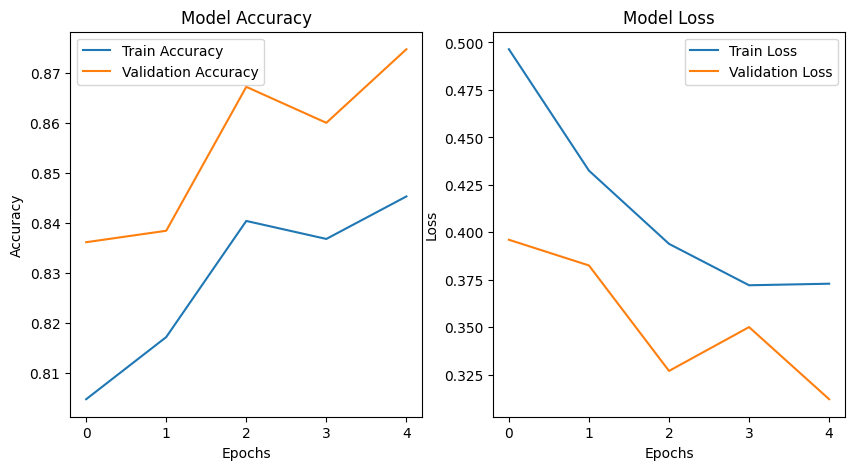

In [60]:
import matplotlib.pyplot as plt

# Plot Accuracy & Loss
plt.figure(figsize=(10, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()


In [61]:
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc:.2f}")


192/192 ━━━━━━━━━━━━━━━━━━━━ 94s 487ms/step - accuracy: 0.8780 - loss: 0.2939
Validation Accuracy: 0.88


## Build a Custom CNN Model


Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.4713 - loss: 8.0574 - val_accuracy: 0.4657 - val_loss: 11.8075
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.4941 - loss: 1.1174 - val_accuracy: 0.6144 - val_loss: 4.1674
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.5199 - loss: 1.0302 - val_accuracy: 0.3235 - val_loss: 2.2594
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.5677 - loss: 0.9616 - val_accuracy: 0.6699 - val_loss: 0.7244
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.5986 - loss: 0.9055 - val_accuracy: 0.3595 - val_loss: 1.5785
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.6149 - loss: 0.8683 - val_accuracy: 0.4902 - val_loss: 1.3405
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.6021 - loss: 0.9249 - val_accuracy: 0.3252 - val_loss: 3.1703
Epoch 8/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.6600 - loss: 0.7648 - val_accuracy: 0.3056 - val_loss: 2.1713
Epoch 9/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.6640 - loss: 0.7545 - val_accuracy: 0.4918 - val_loss: 1.4378
Epoch 10/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.6974 - loss: 0.7040 - val_accuracy: 0.6634 - val_loss: 1.0000

📌 Key Observations from Your Results
✔ Accuracy is increasing (from 47% → 69% on training).
✔ Validation accuracy is inconsistent (goes from 66% → 32% → 66%).
✔ Loss fluctuates (peaks at 11.8, then drops to 0.7, but later increases again).
✔ Overfitting Risk – Training accuracy is rising, but validation fluctuates → Possible overfitting.

In [69]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 1)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),  # 🔹 NEW: Add dropout

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),  # 🔹 NEW: Add dropout

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.4),  # 🔹 NEW: Increase dropout

    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.5),  # 🔹 NEW: Increase dropout

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # 🔹 Keep dropout in Dense layer

    Dense(3, activation='softmax')  # Output layer
])



In [70]:
from tensorflow.keras.optimizers import Adam

# Use Adam with scheduled learning rate decay
optimizer = Adam(learning_rate=0.001, decay=1e-5)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [71]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,  # 🔹 Increased rotation
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,  # 🔹 Increased zoom
    brightness_range=[0.7, 1.3],  # 🔹 Adjust brightness
    horizontal_flip=True,
    validation_split=0.2
)


In [72]:
#sputit zitra znovu, nechat proběhnout
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,  # 🔹 Increase epochs, but stop early if needed
    callbacks=[early_stopping]
)


Epoch 1/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.4333 - loss: 4.7767 - val_accuracy: 0.4657 - val_loss: 7.3787
Epoch 2/20
 62/154 ━━━━━━━━━━━━━━━━━━━━ 1:44 1s/step - accuracy: 0.5266 - loss: 1.0670

KeyboardInterrupt: 

🚀 Summary: What to Change
Fix	Why?	Expected Improvement
- Increase Dropout	Reduces overfitting	More stable accuracy
- Use Learning Rate Decay	Prevents loss from fluctuating	Smooth training curve
- Improve Data Augmentation	Increases dataset variety	Better generalization
- Use Early Stopping	Stops training at best epoch	Prevents wasted epochs
- Train for Longer	Model is still improving	Higher final accuracy

We will try several improvements to experiment with the architecture:

1. Increase Model Depth – Add more convolutional layers to extract better features.
2. Use Batch Normalization – Helps stabilize and speed up training.
3. Use Dropout Regularization – Reduces overfitting.
4. Try Different Optimizers – Adam, RMSprop, SGD (with learning rate tuning).
5. Adjust Kernel Sizes – Using different sizes like (5x5) instead of (3x3).


Step 3: Model Selection
Use a CNN (Convolutional Neural Network) for feature extraction.
Consider Transfer Learning (e.g., ResNet50, VGG16, EfficientNet).
Experiment with architectures to improve accuracy.

Step 4: Training the Model
Split the dataset into training, validation, and test sets.
Use categorical cross-entropy loss and Adam optimizer.
Monitor performance using accuracy and confusion matrices.

Step 5: Evaluation and Optimization
Tune hyperparameters (learning rate, batch size, dropout).
Implement early stopping and learning rate scheduling.
Generate a classification report with precision, recall, and F1-score.

Step 6: Deployment & Visualization
Deploy as a simple web app (Streamlit or Flask) for user-friendly interaction.
Visualize activations using Grad-CAM to interpret model decisions.